# AI - CA4 - Machine Learning - Ava KazemiNejad

## Goal
In this assignment, we're going to explore diabetes dataset and train some models to predict songs' genres. Let's start!

## Overall approach
In order to train the models, we first visualize data. Then we preprocess it and finally we'll tune hyperparameters, train the model and evaluate the results. Let's import the necessary libraries:

In [1]:
# Libraries for preprocessing
import nltk
import re

# Scientific libraries 
import numpy as np
import pandas as pd
import sklearn as sk

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Phase 0: EDA and visualization
First we need to read the data:

In [2]:
db = pd.read_csv('/content/diabetes.csv')

data = db.iloc[:, :-1]
label = db.iloc[:, -1]

We'll explore the data using describe and info methods:

In [3]:
db.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,635.000000,654.000000,680.000000,624.000000,680.000000,684.000000,590.000000,655.000000,768.000000
mean,3.700787,113.422018,68.786765,20.386218,80.123529,32.083626,0.466676,33.157252,0.348958
std,3.518126,202.816831,19.724841,15.987049,115.681140,7.800741,0.322408,13.829831,0.476951
min,-22.000000,-5000.000000,-2.000000,0.000000,0.000000,0.000000,0.078000,-150.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.375000,0.243250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.300000,0.368000,29.000000,0.000000
75%,6.000000,140.750000,80.000000,32.000000,129.250000,36.600000,0.611500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.329000,81.000000,1.000000


We can see the count, mean, standard deviation, min, max and quartiles of numerical values.

Now let's try info method:

In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               635 non-null    float64
 1   Glucose                   654 non-null    float64
 2   BloodPressure             680 non-null    float64
 3   SkinThickness             624 non-null    float64
 4   Insulin                   680 non-null    float64
 5   BMI                       684 non-null    float64
 6   DiabetesPedigreeFunction  590 non-null    float64
 7   Age                       655 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


As you can see, pregnancies, glucose and temp columns have some null values, which should be handled in preprocessing phase. Let's see the percentage of null values for each feature:

In [5]:
print('Percentage of NaN values in dataset per feature:')
for feature in db:
    print(feature, ":", db[feature].isnull().sum() * 100 / len(db), "%")

Percentage of NaN values in dataset per feature:
Pregnancies : 17.317708333333332 %
Glucose : 14.84375 %
BloodPressure : 11.458333333333334 %
SkinThickness : 18.75 %
Insulin : 11.458333333333334 %
BMI : 10.9375 %
DiabetesPedigreeFunction : 23.177083333333332 %
Age : 14.713541666666666 %
Outcome : 0.0 %


Finally, we'll plot histograms and KDE to see the distribution of each feature:

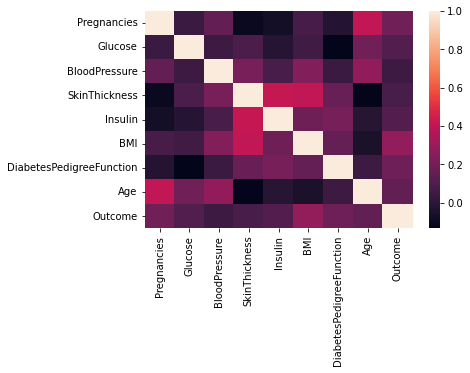

In [6]:
import seaborn as sns 
sns.heatmap(db.corr())

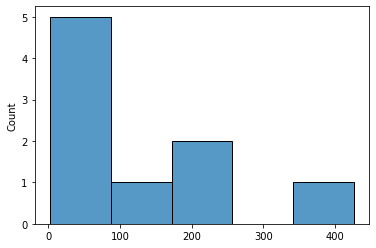

In [7]:
sns.histplot(db.nunique())

In [ ]:
sns.pairplot(db, vars = db.columns[0:-1], hue='Outcome')

In [ ]:
def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    ax = plt.gca()
    xmin, xmax = min_series[x.name], max_series[x.name]
    ymin, ymax = min_series[y.name], max_series[y.name]
    plt.hexbin(x, y, gridsize=15, cmap=cmap, extent=[xmin, xmax, ymin, ymax], **kwargs)

g = sns.PairGrid(db, hue='Outcome')
g.map_diag(plt.hist)
g.map_lower(plt.scatter, alpha=0.5)
g.map_upper(hexbin, min_series=db.min(), max_series=db.max(), alpha=0.5)


In [ ]:
from pandas.api.types import is_numeric_dtype
for feature in db:
    if feature != 'pregnancies' and feature != 'age':
        plt.figure()
        plt.xticks(rotation = 45)
        if is_numeric_dtype(db[feature]):
            plt.title('KDE of {}'.format(feature))
            db[feature].plot.kde()
            plt.ylabel('Density')
        else:
            plt.title('Histogram of {}'.format(feature))
            db[feature].hist()
            plt.ylabel('Frequency')
        plt.xlabel(feature)
        plt.show()

As you can see, the distribution of numerical values follows a Guassian distribution.

Before doing anything new, let's seperate X and y dataframes from the dataset:

In [ ]:
X, y = db.drop(['Outcome'], axis=1, inplace=False) , db['Outcome']

## Phase 1: Preprocessing
To remove NaN values from the dataframe, the most frequent value of each column is registered as the replaced value.
The first method is imputation Using (Most Frequent) or (Zero/Constant) Values:
This method is used for categorical features, but it doesn’t factor the correlations between features and it can introduce bias in the data. Another possible method is imputation Using (Mean/Median) Values which is used for numerical values.
Another approach is to drop the entire column or row, which leads to losing some data. Final approach is to predict the NaN values based on other features(like using Linear Regression or other machine learning methods), which can introduce bias in data. 

Let's fill NaN values based on first and second approach:

In [ ]:
for i in X.columns[X.isnull().any(axis=0)]:
    if is_numeric_dtype(X[i]):
        X[i].fillna(X[i].mean(), inplace=True)
    elif i != 'y':
        X[i].fillna(X[i].mode()[0], inplace=True)

In [ ]:
X.isna().sum()

Now let's try normalization/standardization. Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling. Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

Scaling avoids raw data and various problems of datasets by creating new values and maintaining general distribution as well as a ratio in data. Further, it also improves the performance and accuracy of machine learning models using various techniques and algorithms.

Since our numerical values follow a guassian distribution, we use standardization method.

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

for feature in X:
    if is_numeric_dtype(X[feature]):
        scaled = StandardScaler().fit(X[[feature]])
        X[feature] = scaled.transform(X[[feature]])

Now let's work with categorical values. There are several methods to convert categorical data into numerical data:
- Label Encoding: Assigining numbers to each categorical value.
- One Hot Encoding: Adding new columns for each categorical value and assigining a binary vector to each row.

Label Encoding isn't a good approach when we have no particular ordering in our categories. In such cases, we can use One Hot Encoding which takes a lot of memory since it is adding a new column for each new category. Since total number of possible values for 'key' and 'mode' isn't that high and there isn't an obvious order in the data, we'll use one-hot encoding for these two features.

Let's see the results:

In [ ]:
X.head()

Let's see the gain for each feature:

In [ ]:
from sklearn.feature_selection import mutual_info_classif

info = mutual_info_classif(X, y)
ig = pd.Series(info)
ig.index = X.columns
ig.sort_values(ascending = False, inplace = True)

plt.title('Mutual information with respect to features')
ig.plot.bar(figsize=(25,20))
plt.show()

Feature selection is the process of reducing the number of input variables when developing a predictive model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

As you can see from the plot, some of the features doesn't give that much gain and we can get rid of them. We choose to keep the first 11 features in the plot to avoid overfitting and undefitting and get a good performance(we ignore minor since if a mode isn't major, it's minor and we don't want to save redundant data). Let's do this:

In [ ]:
for column in X.columns:
    if column not in ig[:11]:
        X.drop(columns=[column], axis=1, inplace=True)

In [ ]:
X

## Phase 2: Model Training, Evaluation and Hyper Parameter Tuning
In the context of Machine Learning, the split of our modelling dataset into training and testing samples is probably one of the earliest pre-processing steps that we need to undertake. The creation of different samples for training and testing helps us evaluate model performance.
ome common inferences that can be derived on dataset split include:

If there are several hyperparameters to tune, the machine learning model requires a larger validation set to optimize the model performance. Similarly, if the model has fewer or no hyperparameters, it would be easy to validate the model using a small set of data.
If a model use case is such that a false prediction can drastically hamper the model performance—like falsely predicting cancer—it’s better to validate the model after each epoch to make the model learn varied scenarios.
With the increase in the dimension/features of the data, the hyperparameters of the neural network functions also increase making the model more complex. In these scenarios, a large split of data should be kept in training set with a validation set.

The truth is-

There is no optimal split percentage.

One has to come to a split percentage that suits the requirements and meets the model’s needs. 

However, there are two major concerns while deciding on the optimum split:

If there is less training data, the machine learning model will show high variance in training.
With less testing data/validation data, your model evaluation/model performance statistic will have greater variance.

Random sampling is the oldest and most popular method for dividing a dataset. As the name suggests, the dataset is shuffled, and samples are picked randomly and put in the train, validation, or the test set based on what percentage ratio is given by the user.

However, this method has a significant drawback. Random sampling works optimally on class-balanced datasets, i.e., datasets with the more or less the same number of samples in every dataset category. In the case of class-imbalanced datasets, such a data splitting method may create a bias.

Stratified sampling for splitting a dataset alleviates the problem of Random Sampling in datasets with an imbalanced-class distribution. Here, the distribution of classes in each of the train, validation, and test sets is preserved.

Stratified sampling is, thus, a more fair way of data splitting, such that the machine learning model will be trained and validated on the same data distribution.

Let's apply these knowledge using 75/25 split percentage:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

## KNN
Let's fit KNN model with different parameters and see the results:

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
neighbours = range(1, 20)

test = []
train = []

for i in neighbours:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)

    train_pred= knn.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = knn.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(neighbours, train, label='Train')
plt.plot(neighbours, test, label='Test')
plt.legend()
plt.title('Accuracy according to n_neighbors')
plt.show()

As you can see, for low neighbours we have high accuracy in train and low accuracy in test, which is a sign of overfitting. Best k, according to plot, is around 15-20. We choose k = 15 for the final model:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train)

## Decision Tree
Let's fit Decision Tree model with different parameters and see the results:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

depths = range(1, 30)

test = []
train = []

for i in depths:
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train,y_train)

    train_pred= tree.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = tree.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(depths, train, label='Train')
plt.plot(depths, test, label='Test')
plt.legend()
plt.title('Accuracy according to depths')
plt.show()

We choose depth = 5 to avoid underfitting and overfitting. Let's try other factor:

In [ ]:
leaves = range(1, 30)

test = []
train = []

for i in leaves:
    tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=i)
    tree.fit(X_train,y_train)

    train_pred= tree.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = tree.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(depths, train, label='Train')
plt.plot(depths, test, label='Test')
plt.legend()
plt.title('Accuracy according to min_samples')
plt.show()

# logistic regression


In [ ]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(ds_train, out_train)
predictions = logisticRegr.predict(ds_test)





def check(x, y, model, name):
    y_pred = model.predict(x)
    print(classification_report(y, y_pred))
    print('Accuracy for {} is {}'.format(name, accuracy_score(y, y_pred)))
    print('--------')

xs = [X_train, X_test]
ys = [y_train, y_test]

models = {
    'tree': tree,
    'knn': knn,
'logistic regression': logisticRegr
}

for model in models.keys():
    for _x, _y in zip(xs, ys):
        check(_x, _y, models[model], model)

We choose min_leaf = 15 to avoid underfitting and overfitting. Let's create the final model:

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)
tree.fit(X_train,y_train)

Underfitting: A statistical model or a machine learning algorithm is said to have underfitting when it cannot capture the underlying trend of the data. (It’s just like trying to fit undersized pants!) Underfitting destroys the accuracy of our machine learning model. Its occurrence simply means that our model or the algorithm does not fit the data well enough. It usually happens when we have fewer data to build an accurate model and also when we try to build a linear model with fewer non-linear data. In such cases, the rules of the machine learning model are too easy and flexible to be applied on such minimal data and therefore the model will probably make a lot of wrong predictions. Underfitting can be avoided by using more data and also reducing the features by feature selection. 

In a nutshell, Underfitting – High bias and low variance 

Techniques to reduce underfitting: 

- Increase model complexity
- Increase the number of features, performing feature engineering
- Remove noise from the data.
- Increase the number of epochs or increase the duration of training to get better results.

Overfitting: 
A statistical model is said to be overfitted when we train it with a lot of data (just like fitting ourselves in oversized pants!). When a model gets trained with so much data, it starts learning from the noise and inaccurate data entries in our data set. Then the model does not categorize the data correctly, because of too many details and noise. The causes of overfitting are the non-parametric and non-linear methods because these types of machine learning algorithms have more freedom in building the model based on the dataset and therefore they can really build unrealistic models. A solution to avoid overfitting is using a linear algorithm if we have linear data or using the parameters like the maximal depth if we are using decision trees. 

In a nutshell, Overfitting – High variance and low bias 
Techniques to reduce overfitting:

- Increase training data.
- Reduce model complexity.
- Early stopping during the training phase (have an eye over the loss over the training period as soon as loss begins to increase stop training).
- Ridge Regularization and Lasso Regularization
- Use dropout for neural networks to tackle overfitting.

In our models, we try to tune hyperparameters to avoid overfitting and underfitting. As you can see, the accuracy in both models are nearly the same for test and train.

## Accuracy
It’s the ratio of the correctly labeled subjects to the whole pool of subjects.
Accuracy is the most intuitive one.
Accuracy answers the following question: How many students did we correctly label out of all the students?
Accuracy = (TP+TN)/(TP+FP+FN+TN)
numerator: all correctly labeled subject (All trues)
denominator: all subjects

## Precision
Precision is the ratio of the correctly +ve labeled by our program to all +ve labeled.
Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
Precision = TP/(TP+FP)
numerator: +ve labeled diabetic people.
denominator: all +ve labeled by our program (whether they’re diabetic or not in reality).

## Recall (aka Sensitivity)
Recall is the ratio of the correctly +ve labeled by our program to all who are diabetic in reality.
Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
Recall = TP/(TP+FN)
numerator: +ve labeled diabetic people.
denominator: all people who are diabetic (whether detected by our program or not)

## F1-score (aka F-Score / F-Measure)
F1 Score considers both precision and recall.
It is the harmonic mean(average) of the precision and recall.
F1 Score is best if there is some sort of balance between precision (p) & recall (r) in the system. Oppositely F1 Score isn’t so high if one measure is improved at the expense of the other.
For example, if P is 1 & R is 0, F1 score is 0.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)




Let's see these metrics for our models:

In [ ]:
def check(x, y, model, name):
    y_pred = model.predict(x)
    print(classification_report(y, y_pred))
    print('Accuracy for {} is {}'.format(name, accuracy_score(y, y_pred)))
    print('--------')

xs = [X_train, X_test]
ys = [y_train, y_test]

models = {
    'tree': tree,
    'knn': knn
}

for model in models.keys():
    for _x, _y in zip(xs, ys):
        check(_x, _y, models[model], model)

Preprocessing is a big step in machine learning. If we dropped tuples with NaN values, we could probably lead to lower accuracy(since we would have less data).

## Phase 3: Ensemble Methods

We use random forest in this phase. Let's see the impact of different hyperparams in the result. Let's go!

The hyper parameters of Random Forest:


- n_estimators: The number of trees in the forest.
- criterion: The function to measure the quality of a split. 
- max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split: The minimum number of samples required to split an internal node:
- bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

depths = range(1, 30)

test = []
train = []

for i in depths:
    forest = RandomForestClassifier(max_depth=i)
    forest.fit(X_train,y_train)

    train_pred= forest.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = forest.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(depths, train, label='Train')
plt.plot(depths, test, label='Test')
plt.legend()
plt.title('Accuracy according to depths')
plt.show()

We choose max_depth = 12 to avoid underfitting and overfitting. Let's continue:

In [ ]:
estimators = range(1, 30)

test = []
train = []

for i in estimators:
    forest = RandomForestClassifier(max_depth=12, n_estimators=i)
    forest.fit(X_train,y_train)

    train_pred= forest.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = forest.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(depths, train, label='Train')
plt.plot(depths, test, label='Test')
plt.legend()
plt.title('Accuracy according to estimators')
plt.show()

We choose n_estimators = 23 to avoid underfitting and overfitting. Let's continue:

In [ ]:
leaves = range(1, 30)

test = []
train = []

for i in leaves:
    forest = RandomForestClassifier(max_depth=12, n_estimators=23, min_samples_leaf=i)
    forest.fit(X_train,y_train)

    train_pred= forest.predict(X_train)
    train.append(accuracy_score(y_train, train_pred))

    test_pred = forest.predict(X_test)
    test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 10))
plt.plot(depths, train, label='Train')
plt.plot(depths, test, label='Test')
plt.legend()
plt.title('Accuracy according to min_samples')
plt.show()

We choose min_samples = 10 to avoid underfitting and overfitting. Let's finalize the model:

In [ ]:
forest = RandomForestClassifier(max_depth=12, n_estimators=23, min_samples_leaf=10)
forest.fit(X_train,y_train)

Let's check the model:

In [ ]:
for _x, _y in zip(xs, ys):
    check(_x, _y, forest, 'forest')

Let's see the confusion matrix for the model:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
matrix = ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, cmap=plt.cm.Reds, ax=ax)
plt.show()

# Conclusion
The process of choosing the right machine learning model to solve a problem can be time consuming if not approached strategically.

Step 1: Align the problem with potential data inputs that should be considered for the solution. This step requires help from data scientists and experts who have a deep understanding of the problem.

Step 2: Collect data, format it and label the data if necessary. This step is typically led by data scientists, with help from data wranglers.

Step 3: Chose which algorithm(s) to use and test to see how well they perform. This step is usually carried out by data scientists.

Step 4: Continue to fine tune outputs until they reach an acceptable level of accuracy. This step is usually carried out by data scientists with feedback from experts who have a deep understanding of the problem.